In [1]:
import mlflow

# Point MLflow at server
mlflow.set_tracking_uri("http://localhost:5000")

# Start a new run and a test metric
with mlflow.start_run():
    mlflow.log_metric("test_metric", 42)

print("Logged test_metric = 42 to local MLflow server")

🏃 View run righteous-quail-432 at: http://localhost:5000/#/experiments/0/runs/4e51901f967e4ba98ccb6756d435f6c4
🧪 View experiment at: http://localhost:5000/#/experiments/0
Logged test_metric = 42 to local MLflow server


In [2]:
import cv2
import glob
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython import get_ipython
from collections import Counter

# move up one directory (only)
cwd = os.getcwd()
if os.path.basename(cwd) == "notebooks":
    get_ipython().run_line_magic("cd", "..")
    print("Moved up to project root:", os.getcwd())
else:
    print("Already at project root:", cwd)

/home/millie/Documents/GitHub/Deepfake-Sentinel
Moved up to project root: /home/millie/Documents/GitHub/Deepfake-Sentinel


In [3]:
# Gather real & fake lists
orig_paths = glob.glob("data/video_raw/original/*.mp4")
fake_paths = glob.glob("data/video_raw/manipulated/*.mp4")

# Combine into one list
video_paths = orig_paths + fake_paths
print(f"Found {len(video_paths)} total videos")

# Create DataFrame with matching labels
video_df = pd.DataFrame({
    "path": video_paths,
    "label": ["real"] * len(orig_paths) + ["fake"] * len(fake_paths)
})

# Peek
video_df.head()
print(video_df.label.value_counts())

Found 3431 total videos
label
fake    3068
real     363
Name: count, dtype: int64


In [4]:
# A helper to grab 1 frame per second
def extract_frames(path, interval_sec=1, max_frames=5):
    
    cap = cv2.VideoCapture(path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 30 # default to 30 if unreadable
    frames = []
    count = 0

    while len(frames) < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        # Grab every 'interval_sec * fps' frames
        if count % int(interval_sec * fps) == 0:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        count += 1
    cap.release()

    return frames

-> Frames extracted from first video: 3


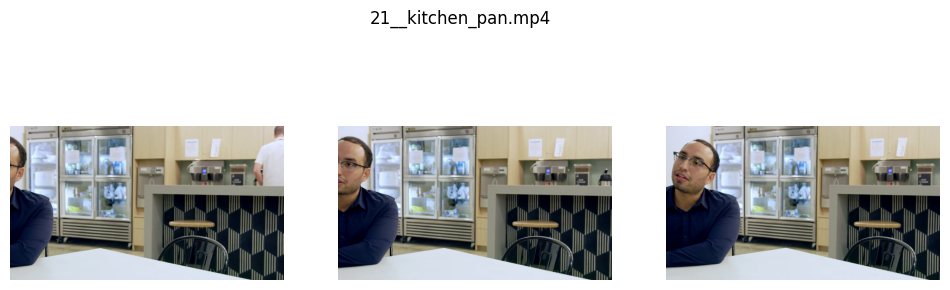

In [5]:
# Shows 3 raw frames, 1 second apart
if video_paths:
    frames = extract_frames(video_paths[0], interval_sec=1, max_frames=3)
    print("-> Frames extracted from first video:", len(frames))
else:
    raise RuntimeError("No videos found at data/video_raw/*.mp4")

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for ax, img in zip(axs, frames):
    ax.imshow(img)
    ax.axis("off")

plt.suptitle(os.path.basename(video_paths[0]))
plt.show()

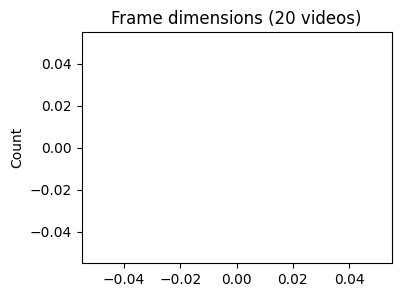

In [6]:
# Gather statistics on dataset
shapes = []
histograms =[]

# How many videos of each dimension
shape_counts = Counter(shapes)

# Print table
for (h,w), count in shape_counts.items():
    print(f"Dimensions {h}x{w}: {count} videos")

# Print bar-plot
dims = [f"{h}x{w}" for (h, w) in shape_counts.keys()]
counts = list(shape_counts.values())

plt.figure(figsize=(4, 3))
plt.bar(dims, counts)
plt.title("Frame dimensions (20 videos)")
plt.ylabel("Count")
plt.show()

### Evidence of Uniformity
This plot is empty prooving that all videos are already of the same dimensions (1080, 1920). There are no edge cases. So we wont have to do this during processing.

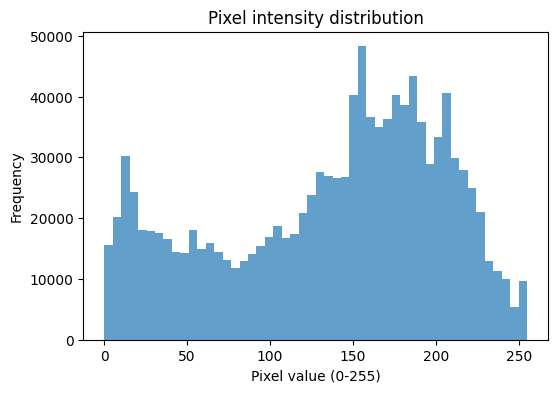

In [7]:
video_paths = glob.glob("data/video_raw/*/*.mp4")[:200] # first 200 videos
frames_list = []

for vp in video_paths:
    f = extract_frames(vp, interval_sec=1, max_frames=1)
    if f:
        frames_list.append(f[0]) # f[0] = RGB array

# Flatten frames into one big array of pixel values
all_pixels = np.concatenate([f[0].ravel() for f in frames_list])

plt.figure(figsize=(6,4))
plt.hist(all_pixels, bins=50, range=(0,255), alpha=0.7)
plt.title("Pixel intensity distribution")
plt.xlabel("Pixel value (0-255)")
plt.ylabel("Frequency")
plt.show()

## Brighness (Pixel-Intensity) Distribution
### Bimodal Shape: 
- Big peak around 160-200 (well lit skintones/indoor lighting/bright backgrounds)
- Small peak around 0-30 (shadows/dark hair/clothing/low-light)
### Mid-tone Valley
- Dip around 80-120 scenes arnt often in 'neutral gray' indicating a contrast bias
### Extreem Highlights/Blacks
- Counts at 0 and 255 exist meaning some pixels are fully white/black

Normalization Stratergy: 
- mean = 160 
- standard deviation = 40

Lighting Outliers: Pure black/white pixels might need:
- Clipping (caps intensity to 5-250)
- Contrast enhancment (spreads out the midtones helping details more prominant)

Model Robustness: (models trained mostly on mid-tone frames will struggle on very bright/dark scenes)
- Random brightness/contrast jitter ()
- Colour jitter (small changes to saturation/hue)
- Gamma correction (simulate over/under exposed footage)